In [31]:
import os
from dotenv import load_dotenv

load_dotenv()

GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
if not GOOGLE_API_KEY:
    raise ValueError("GOOGLE_API_KEY not found. Please add it to your .env file.")

os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [32]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages


class OrderState(TypedDict):
    """State representing the customer's order conversation."""

    # The chat conversation. This preserves the conversation history
    # between nodes. The `add_messages` annotation indicates to LangGraph
    # that state is updated by appending returned messages, not replacing
    # them.
    messages: Annotated[list, add_messages]

    # The customer's in-progress order.
    cart: list[str]

    # Flag indicating that the order is placed and completed.
    finished: bool


# The system instruction defines how the chatbot is expected to behave and includes
# rules for when to call different functions, as well as rules for the conversation, such
# as tone and what is permitted for discussion.
SHOPBOT_SYSINT = (
    "system",  # 'system' indicates the message is a system instruction.
    "You are a virtual shopping assistant. Help users browse, add items to cart, remove them, view the total, and checkout."
    " A user will talk to you about the "
    "available items you have and you will answer any questions about items (and only about "
    "items - no off-topic discussion, but you can chat about the products and their history). "
    "The user will place an order for 1 or more items from the list of products, which you will structure "
    "and then calculate the total and checkout confirming the order with the user. "
    "\n\n"
    "Add items to the user's cart with add_to_cart, and reset the cart with clear_cart. "
    "To see the contents of the cart so far, call view_cart (this is shown to you, not the user) "
    "Always confirm_cart with the user (double-check) before calling checkout. Calling confirm_cart will "
    "display the cart items to the user and returns their response to seeing the list. Their response may contain modifications. "
    "Always verify and respond with product name and price before adding them to the cart. "
    "If you are unsure a product matches those on the product list, ask a question to clarify or redirect. "
    "You can view the available products with view_products, which will return a list of products "
    "Once the customer has finished ordering items, Call confirm_cart to ensure it is correct then make "
    "any necessary updates and then call checkout. In checkout, display the total of the items in cart to the user. Once checkout has returned, thank the user and "
    "say goodbye!"
    "\n\n"
    "If any of the tools are unavailable, you can  tell the user that "
    "they have not implemented them yet and should keep reading to do so.",
)

# This is the message with which the system opens the conversation.
WELCOME_MSG = "Welcome to ShopBot! Type `q` to quit. What would you like to buy?"

In [33]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from IPython.display import Image, display

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")


In [34]:
from langchain_core.messages.ai import AIMessage


def human_node(state: OrderState) -> OrderState:
    """Display the last model message to the user, and receive the user's input."""
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)

    user_input = input("User: ")

    # If user types 'q', 'quit', 'exit', or 'goodbye', set the finished state to True.
    if user_input in {"q", "quit", "exit", "goodbye"}:
        state["finished"] = True

    return state | {"messages": [("user", user_input)]}


In [35]:
from typing import Literal

# The `maybe_exit_human_node` function routes to the chatbot unless the user has indicated they want to exit.
def maybe_exit_human_node(state: OrderState) -> Literal["chatbot", "__end__"]:
    """Route to the chatbot, unless it looks like the user is exiting."""
    # if state.get("finished", False):
    #     return END
    # else:
    #     return "chatbot"
    
    if state.get("finished", False):
        print("Bot:", state["messages"][-1].content)  # final message
        return END
    else:
        return "chatbot"



In [36]:
from langchain_core.tools import tool


@tool
def get_products() -> str:
    """This function returns the current menu of drinks and modifiers."""
    
    return """
    PRODUCTS:
    Electronics:
    Laptop $999
    Smartphone $800 
    Tablet $499


    GROCERY:
    Bread $2.00
    Milk $3.00
    Tomato $1.50
    Onions: $0.50
    Eggs: $2.50

    SKINCARE:
    Moisturizer $25.00
    Sunscreen $15.00
    Shampoo $10.00
    Conditioner $12.00

  """

In [37]:
from langgraph.prebuilt import ToolNode


# Define the tools and create a "tools" node.
tools = [get_products]
tool_node = ToolNode(tools)

# Attach the tools to the model so that it knows what it can call.
llm_with_tools = llm.bind_tools(tools)

def chatbot_with_tools(state: OrderState) -> OrderState:
    """The chatbot with tools. A simple wrapper around the model's own chat interface."""
    defaults = {"cart": [], "finished": False}

    if state["messages"]:
        new_output = llm_with_tools.invoke([SHOPBOT_SYSINT] + state["messages"])
    else:
        new_output = AIMessage(content=WELCOME_MSG)

    # Set up some defaults if not already set, then pass through the provided state,
    # overriding only the "messages" field.
    
    return defaults | state | {"messages": state["messages"] + [new_output]}



In [38]:
from collections.abc import Iterable
from random import randint

from langchain_core.messages.tool import ToolMessage

# These functions have no body; LangGraph does not allow @tools to update
# the conversation state, so you will implement a separate node to handle
# state updates. Using @tools is still very convenient for defining the tool
# schema, so empty functions have been defined that will be bound to the LLM
# but their implementation is deferred to the order_node.


@tool
def add_to_cart(name: str,price:str ) -> str:
    """Adds the product to the cart along with the name and price.

    Returns:
      The updated cart in progress.
    """


@tool
def confirm_cart() -> str:
    """Asks the customer if the order is correct.

    Returns:
      The user's free-text response.
    """


@tool
def get_cart() -> str:
    """Returns the users order so far. One item per line."""


@tool
def clear_cart():
    """Removes all items from the user's order."""


@tool
def checkout() -> int:
    """Calculates the total and places the order.

    Returns:
      The total amount of the order in dollars.
    """


def order_node(state: OrderState) -> OrderState:
    """The ordering node. This is where the order state is manipulated."""
    tool_msg = state.get("messages", [])[-1]
    cart = state.get("cart", [])
    outbound_msgs = []
    order_placed = False

    for tool_call in tool_msg.tool_calls:

        if tool_call["name"] == "add_to_cart":

            # Each order item is just a string. This is where it assembled as "drink (modifiers, ...)".
            price = tool_call["args"]["price"]
            

            cart.append(f'{tool_call["args"]["name"]} ${price}')
            response = "\n".join(cart)

        elif tool_call["name"] == "confirm_cart":

            

            # In a real scenario, this is where you would connect your POS screen to show the
            # order to the user.

            print("Your cart:")
            if not cart:
                print("  (no items)")

            for item in cart:
                print(f"  {item}")

            response = input("Is this correct? ")

        elif tool_call["name"] == "get_cart":

            response = "\n".join(cart) if cart else "(no order)"

        elif tool_call["name"] == "clear_cart":

            cart.clear()
            response = None

        elif tool_call["name"] == "checkout":


            # Calculate the total and place the order.
            # TODO(you!): Implement cafe.
            
            if not cart:
                response = "Your cart is empty. Please add items before checking out."
            else:
                total = 0
                
                for item in cart:
                    
                    try:
                        price_part = item.split("$")[-1]
                        total += float(price_part)
                    except Exception as e:
                        print(f"Warning: Could not parse price from '{item}'. Error: {e}")
                summary = "\n".join([f"- {item}" for item in cart])
                order_placed = True
                response = (
                    f"Placing your order!\n\nItems:\n{summary}\n\n"
                    f"Total: ${total:.2f}\n"
                    f"Thank you for shopping with us!"
                )
                print(response)
                
                

        else:
            raise NotImplementedError(f'Unknown tool call: {tool_call["name"]}')

        # Record the tool results as tool messages.
        outbound_msgs.append(
            ToolMessage(
                content=response,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )

    return {"messages": outbound_msgs, "cart": cart, "finished": order_placed}


def maybe_route_to_tools(state: OrderState) -> str:
    """Route between chat and tool nodes if a tool call is made."""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    msg = msgs[-1]

    if state.get("finished", False):
        # When an order is placed, exit the app. The system instruction indicates
        # that the chatbot should say thanks and goodbye at this point, so we can exit
        # cleanly.
        return END
    
    

    elif hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        # Route to `tools` node for any automated tool calls first.
        if any(
            tool["name"] in tool_node.tools_by_name.keys() for tool in msg.tool_calls
        ):
            return "tools"
        else:
            return "ordering"

    else:
        return "human"

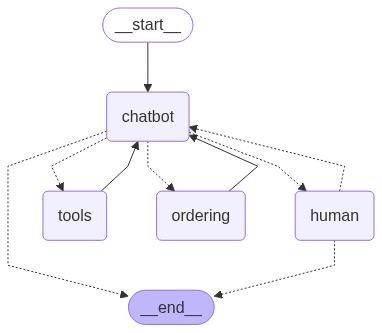

In [39]:
# Auto-tools will be invoked automatically by the ToolNode
auto_tools = [get_products]
tool_node = ToolNode(auto_tools)

# Order-tools will be handled by the order node.
order_tools = [add_to_cart, confirm_cart, get_cart, clear_cart, checkout]

# The LLM needs to know about all of the tools, so specify everything here.
llm_with_tools = llm.bind_tools(auto_tools + order_tools)


graph_builder = StateGraph(OrderState)

# Nodes
graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("ordering", order_node)

# Chatbot -> {ordering, tools, human, END}
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
# Human -> {chatbot, END}
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# Tools (both kinds) always route back to chat afterwards.
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("ordering", "chatbot")

graph_builder.add_edge(START, "chatbot")
graph_with_order_tools = graph_builder.compile()

Image(graph_with_order_tools.get_graph().draw_mermaid_png())

In [40]:
config = {"recursion_limit":200}
# Uncomment this line to execute the graph:
state = graph_with_order_tools.invoke({"messages": []}, config)

# Things to try:
# - Order a drink!
# - Make a change to your order.
# - "Which teas are from England?"
# - Note that the graph should naturally exit after placing an order.

# pprint(state)

Model: Welcome to ShopBot! Type `q` to quit. What would you like to buy?
Model: We have a variety of products in electronics, grocery, and skincare. In electronics, we have Laptop ($999), Smartphone ($800), and Tablet ($499). In grocery, we have Bread ($2.00), Milk ($3.00), Tomato ($1.50), Onions ($0.50), and Eggs ($2.50). Lastly, in skincare, we have Moisturizer ($25.00), Sunscreen ($15.00), Shampoo ($10.00), and Conditioner ($12.00). What would you like to buy?
Model: Okay, that's a Laptop for $999. Would you like me to add that to your cart?
Model: Okay, I've added a Laptop to your cart for $999. What else would you like to buy?
Model: Okay, that's a Smartphone for $800. Would you like me to add that to your cart?
Model: Okay, I've added a Smartphone to your cart for $800. Anything else?
Your cart:
  Laptop $999
  Smartphone $800
Model: Okay, so you're all set with the Laptop ($999) and Smartphone ($800)?
Placing your order!

Items:
- Laptop $999
- Smartphone $800

Total: $1799.00
T